# Forecast:  Montecarlo VS Euler-Maruyama

Install libraries

In [ ]:
pip install pandas-montecarlo

In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas_montecarlo
import numpy as np
import pandas as pd

Download Data:

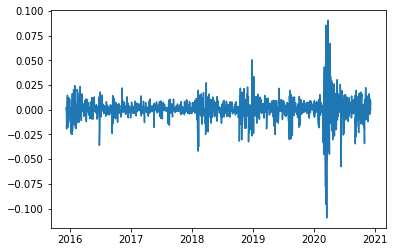

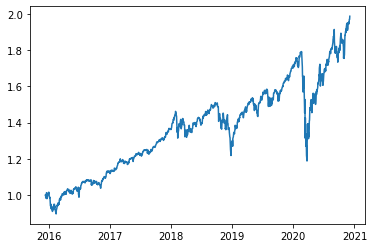

,High,Low,Open,Close,Volume,Adj Close,return,cum_return,balance
Date,,,,,,,,,
2015-12-09,208.679993,204.179993,206.190002,205.339996,162401500.0,186.122940,0.000000,1.000000,1000.000000
2015-12-10,207.429993,205.139999,205.419998,205.869995,116128900.0,186.603348,0.002581,1.002581,1002.581131
2015-12-11,204.139999,201.509995,203.350006,201.880005,211173300.0,182.986755,-0.019381,0.983150,983.149929
2015-12-14,203.050003,199.949997,202.070007,202.899994,182385200.0,183.911285,0.005052,0.988117,988.117238
2015-12-15,206.110001,202.869995,204.699997,205.029999,154069600.0,185.841949,0.010498,0.998490,998.490296
...,...,...,...,...,...,...,...,...,...
2020-11-30,363.119995,359.170013,362.829987,362.059998,83872700.0,362.059998,-0.004427,1.945273,1945.273363
2020-12-01,367.679993,364.929993,365.570007,366.019989,74505000.0,366.019989,0.010937,1.966550,1966.549577
2020-12-02,366.959991,364.200012,364.820007,366.790009,45927000.0,366.790009,0.002104,1.970687,1970.686732


In [ ]:
balance = 1000

df = data.get_data_yahoo("SPY")
df['return'] = df['Adj Close'].pct_change().fillna(0)
df['cum_return'] = (df['return'] + 1).cumprod() 
df['balance'] = df['cum_return'] * balance

plt.plot(df['return'])
plt.show()
plt.plot(df['cum_return'])
plt.show()

df

Split Data

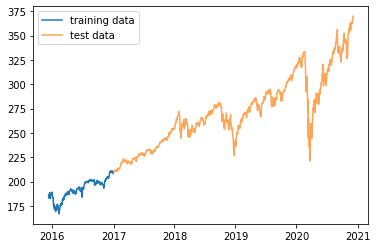

In [ ]:
#split data into train, and test
start_date = '2015'              
split_date = '2017'           #it could be only a year, 'year-month' or 'year-month-day'
train_data = df.loc[start_date : split_date[0:-1] + str(int(split_date[-1])-1)]
test_data = df.loc[split_date:]

#plotting price data
plt.plot(train_data['Adj Close'],label='training data')
plt.plot(test_data['Adj Close'],alpha=0.7,label='test data')
plt.legend()

## Simulacion de Montecarlo

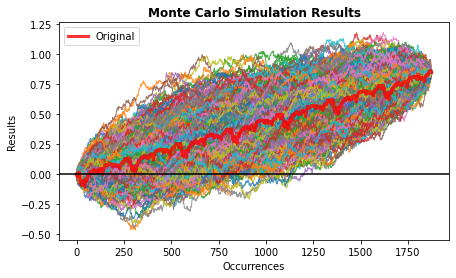

In [ ]:
n_sims = 1000

returns = pd.concat([train_data['return'], train_data['return'], train_data['return'], train_data['return'], train_data['return'], train_data['return'], train_data['return']])
mc = returns.montecarlo(sims=n_sims)#, bust=-0.1, goal=1)
mc.plot(figsize=(7,4))

Convert Random Returns into Trajectories

In [ ]:
mc_cum = (mc.data + 1).cumprod()
mc_cum

,original,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.002496,0.997715,1.000000,1.001486,1.013646,1.017027,0.999909,1.000000,1.002058,0.993401,0.997601,1.002496,1.005995,1.003154,0.988034,0.998894,0.999777,0.984883,1.000516,1.001568,1.001419,1.004388,0.997045,0.986021,0.997217,1.010602,1.014479,1.002697,0.991286,1.000798,1.000000,1.016417,1.014890,0.992755,1.004492,0.992912,1.014890,1.000798,1.002667,...,1.004508,1.020515,0.998044,1.000990,0.999171,1.000290,1.003920,0.999909,1.000516,0.999404,0.991736,0.998718,0.996571,0.996649,0.998894,1.004388,0.994842,1.007552,0.996725,1.004253,1.004576,0.990924,1.002923,1.002923,0.996762,1.001615,1.004253,1.020515,1.001953,1.004576,0.999777,0.992912,0.999380,1.001953,0.989117,0.990645,0.998983,1.000293,0.999171,1.000188
1,1.002581,1.009186,0.992569,0.994601,0.997756,1.017819,1.001653,1.001373,0.999137,1.008279,1.002652,0.997227,1.001345,1.009543,0.990105,1.002340,1.002417,1.010696,0.982520,1.003357,1.001345,1.004578,1.008900,0.993583,0.988819,0.996995,1.015866,1.020564,1.026267,0.967504,1.015289,1.004163,1.009052,1.009699,0.987395,1.006452,0.987791,1.019928,1.007011,1.000760,...,0.997389,1.024515,1.001192,0.995586,1.002883,1.007104,1.010758,0.981888,0.999174,0.995311,0.986302,0.999233,0.996571,1.004801,0.994322,1.002751,0.981451,1.000251,0.991364,1.000963,1.003207,0.991515,0.990922,0.999046,1.002740,1.002414,0.994879,1.014823,1.015060,0.990532,1.000244,0.992960,1.002631,0.998481,1.002614,0.985217,0.994293,1.006969,0.989176,0.996836
2,0.983150,1.008074,0.990348,0.994601,1.004524,1.016698,1.006586,0.999492,1.005130,1.012430,0.987495,1.001718,1.005280,1.022629,0.990389,0.994067,1.000690,1.008719,0.989185,1.004145,1.006955,0.996831,1.010377,0.995812,0.989609,0.982663,1.015236,1.020611,1.032434,0.973317,1.001622,1.003010,1.015454,1.014890,0.994851,1.005827,0.989824,1.012699,1.014868,0.988120,...,0.992024,1.020555,0.997322,1.001568,1.000870,1.010048,1.020108,0.979968,0.987218,0.993591,0.985255,0.999524,1.012850,1.012389,0.997472,1.003045,0.973754,1.012638,0.988671,0.999620,1.003011,0.989576,0.988641,0.998451,1.005196,1.000107,0.997362,1.004671,1.014361,0.991832,1.001709,0.999178,1.003329,1.002728,1.000181,0.982779,0.990659,1.017645,0.988818,0.997529
3,0.988117,1.017399,0.990155,0.981855,1.005354,1.006527,1.006140,0.991242,1.005594,1.011072,0.984073,1.004891,1.009880,1.019574,1.004729,0.995371,1.001681,1.010686,0.987339,1.003522,1.006509,0.998706,1.011544,0.996354,0.983268,0.982471,1.002415,1.027422,1.037811,0.969937,0.988987,1.011284,1.013704,1.033195,0.992558,1.005875,0.991817,1.013297,1.028084,0.988410,...,0.997971,1.025802,1.004330,1.001622,0.975907,0.990806,1.011677,0.978279,0.992361,1.002607,0.974440,1.000024,1.015725,0.998236,1.000618,0.995178,0.978760,1.024025,0.989461,1.001797,1.010296,0.980952,0.985830,0.997589,1.004088,1.002795,1.001835,0.980567,1.015846,0.983200,0.996586,1.003563,1.008309,0.999937,1.006191,0.982779,0.999823,1.015965,0.987186,0.989706
4,0.998490,1.020622,0.990667,0.976791,1.003985,1.003230,0.996604,0.984060,1.004486,1.009173,0.978760,1.004938,1.007978,1.009391,1.003360,0.997840,0.997096,1.023848,0.984030,1.001632,0.981405,1.000272,1.010134,1.008692,0.979861,0.980779,0.993317,1.027469,1.021997,0.975752,0.988767,1.004610,1.011272,1.031229,0.992606,1.003514,0.989124,1.022734,1.028644,0.987275,...,0.998768,1.023263,1.018035,1.000559,0.975541,0.995701,1.014187,0.976437,0.996048,1.002516,0.980326,0.999155,1.022862,1.000333,1.000256,0.997218,0.984889,1.020999,0.993906,1.008249,1.007845,0.968192,0.995681,0.961767,1.012190,1.018977,1.000817,0.980431,1.010179,0.988890,0.992923,1.005619,0.995574,1.002038,1.023323,0.981780,1.001704,1.024162,0.987141,1.010010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

Create Bands and Mean

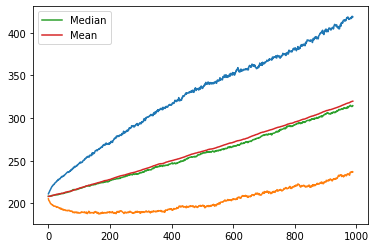

In [ ]:
n1 = len(train_data)
n2 = len(test_data)

a = 0.05

U_ = []  # Upper band
L_ = []  # Lower band
Median_ = []
Mean_ = []

for i in range(n2):
  U_.append((np.quantile(mc_cum.iloc[i],1-a))*train_data['Adj Close'].iloc[-1])
  L_.append((np.quantile(mc_cum.iloc[i],a))*train_data['Adj Close'].iloc[-1])
  Median_.append((np.quantile(mc_cum.iloc[i],0.5))*train_data['Adj Close'].iloc[-1])
  Mean_.append(np.mean(mc_cum.iloc[i])*train_data['Adj Close'].iloc[-1])

plt.plot(U_)
plt.plot(L_)
plt.plot(Median_, label='Median')
plt.plot(Mean_, label='Mean')
plt.legend()

Plot simulation

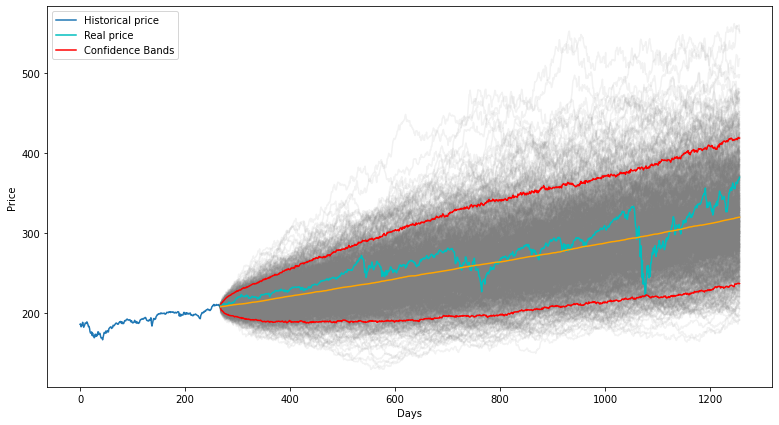

In [ ]:
plt.figure(figsize=(13,7))
plt.plot(train_data['Adj Close'].values, label='Historical price')
for i in range(1, n_sims):
    sim = (mc_cum[i] * train_data['Adj Close'].iloc[-1])[:n2]
    plt.plot(range(n1, n1+n2, 1), sim, '0.5', alpha=.1, color='gray')
plt.plot(range(n1, n1+n2, 1), test_data['Adj Close'].values, 'c', label="Real price")
plt.plot(range(n1, n1+n2, 1), U_[:n2], 'r', label='Confidence Bands')
plt.plot(range(n1, n1+n2, 1), L_[:n2], 'r')
plt.plot(range(n1, n1+n2, 1), Mean_[:n2], 'orange')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()

## Simulación Estocástica Euler-Maruyama
###Bandas de Confianza
#### Mateo Restrepo S

Bajo ciertas condiciones un conjunto de datos puede ser representado por
(Mirar pdf donde se específican bien cuales son):

$ dX_t = F(t)X_tdt + G(t)X_tdB_t, \quad X_{t_0} = X_0 $

Para todos los calculos posteriores se utilizará el precio de cierre

In [ ]:
close_d1 = train_data['Adj Close'].to_numpy()  # Data from year 1
n1 = len(close_d1)                                 # Number of days of year 1
close_d2 = test_data['Adj Close'].to_numpy()  # Data from year 2
n2 = len(close_d2)                                 # Number of days of year 2

Para este caso consideremos $F(t) = \mu$ y $G(t) = \sigma$ $\longrightarrow$ Parámetros constantes

Su estimación está dada por:

\begin{equation}
\hat{\mu}=\frac{\bar{R}_{i}}{\Delta t} \quad \hat{\sigma}=\sqrt{\frac{1}{\Delta t} \operatorname{Var}\left[R_{i}\right]}, \qquad donde\quad R_i = log\left(\frac{S_t}{S_{t-1}}\right)
\end{equation}

 Primero calculemos los retornos instantáneos

In [ ]:
# Instant Returns
def returns(data):
    dt_i = 1/n1                  # Delta_t
    R_i = []                     # Instant returns
    for i in range(1, n1):
        R_i.append(np.log(data[i] / data[i - 1]))
    return R_i, dt_i

R_i, dt_i = returns(close_d1)
print(R_i)

[0.002577805733287523, -0.01957145398562219, 0.005039721575950384, 0.010443081637251371, 0.014525979218887217, -0.015355432222585801, -0.01797551278060324, 0.008215185602505115, 0.009033477038422586, 0.01230726574835907, -0.0016519222306446153, -0.0022873563112293907, 0.010615110333104796, -0.007112935429286327, -0.010053862215629253, -0.014078106161105745, 0.0016900181433575103, -0.01269455326502885, -0.024283752664985832, -0.011037428409532918, 0.0009896204835569673, 0.008035902774208487, -0.02525701972593583, 0.016283463920164932, -0.02169975673764841, 0.0013301528457850898, -0.012897831109947236, 0.005586441492213665, 0.0203076490159895, -0.015232031320244685, 0.013550741582302234, -0.010942633775951463, 0.005195543246150441, 0.02408502150737559, -0.0003615033845205767, -0.018186556696514162, 0.00597704272166144, 0.001567000093860516, -0.01923369047480312, -0.013552597930733637, 5.3789147637301096e-05, -0.0008630512379052538, -0.013093610226750338, 0.02040739165585614, 0.0167373545

Ahora estimemos los parámetros

In [ ]:
def params(R, dt_i):
    mu = np.mean(R)/dt_i         # Drift
    s = np.sqrt(np.var(R)/dt_i)  # Variance
    return mu, s

mu, s = params(R_i, dt_i)
print(mu, s)

0.11247880090967236 0.1377584718311119


Para simular esto, se puede utilizar la aproximación de Euler-Maruyama (Ver Clase 11 diapositiva 5)

\begin{equation}
    X_{t_i} = X_{t_{i-1}} + \mu X_{t_{i-1}} \Delta t_i + \sigma X_{t_{i-1}} \Delta B_i
\end{equation}

In [ ]:
def sim(data, dt_i, mu, s, n_traj):
    xs_n = []
    for traj in range(1, n_traj+1):
        xs = [data[-1]]
        for i in range(1, n2):
            e = np.random.normal()
            dB_i = np.sqrt(dt_i)*e
            xs.append(xs[i-1] + mu*xs[i-1]*dt_i + s*xs[i-1]*dB_i)
        xs_n.append(xs)
    return xs_n

n_traj = 1000
xs_n = sim(close_d1, dt_i, mu, s, n_traj)

Veamos esto gráficamente que representa $\rightarrow$ Mostrar una y múltiples

Text(0, 0.5, 'Price')

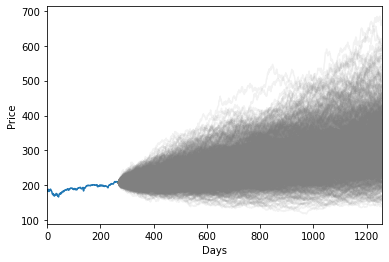

In [ ]:
plt.plot(close_d1)  # Plot the first year (Data use to forecast)
#plt.plot(range(n1, n1+n2, 1), xs_n[0]) # For one trajectory

# Multiple trajectories
for traj in range(n_traj-1):
    plt.gray()
    plt.plot(range(n1, n1+n2, 1), xs_n[traj], '0.5', alpha=.1)

plt.xlim([0, n1+n2])
plt.xlabel("Days")
plt.ylabel("Price")

Ahora calculemos las bandas de confianza

- Banda superior $\longrightarrow$ Cuantil $(1-\alpha)$ de los datos.
- Banda inferior $\longrightarrow$ Cuantil $\alpha$ de los datos

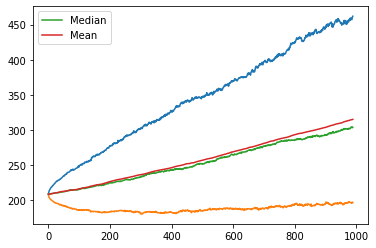

In [ ]:
def bands(xs_n, a):
    U = []  # Upper band
    L = []  # Lower band
    Median = []
    Mean = []
    for t in range(n2):
        data_t = np.array([x[t] for x in xs_n])
        U.append(np.quantile(data_t, 1-a))
        L.append(np.quantile(data_t, a))
        Median.append(np.quantile(data_t, 0.5))
        Mean.append(np.mean(data_t))
    return U, L, Median, Mean

a = 0.05
U, L, Median, Mean = bands(xs_n, a)

plt.plot(U)
plt.plot(L)
plt.plot(Median, label='Median')
plt.plot(Mean, label='Mean')
plt.legend()

Veamos esto gráficamente

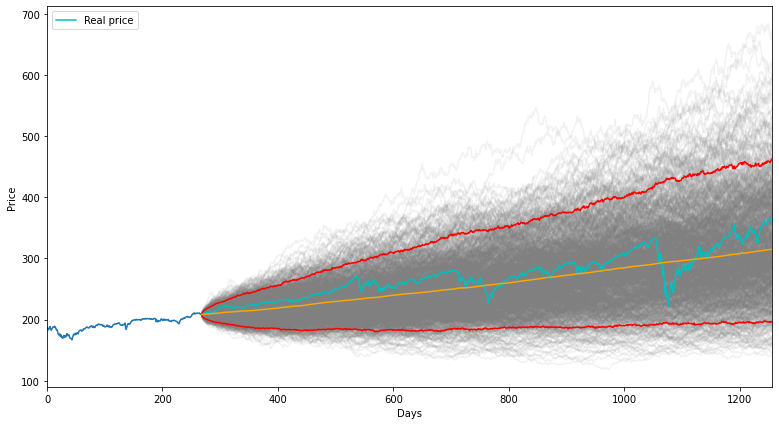

In [ ]:
plt.figure(figsize=(13,7))
plt.plot(close_d1)  # Plot the first year (Data use to forecast)
for traj in range(n_traj-1):
    plt.gray()
    plt.plot(range(n1, n1+n2, 1), xs_n[traj], '0.5', alpha=.1)

plt.plot(range(n1, n1+n2, 1), close_d2, 'c', label="Real price")
plt.plot(range(n1, n1+n2, 1), U, 'r')
plt.plot(range(n1, n1+n2, 1), L, 'r')
plt.plot(range(n1, n1+n2, 1), Mean, 'orange')
plt.xlim([0, n1+n2])
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()

## Montecarlo VS Euler-Maruyama

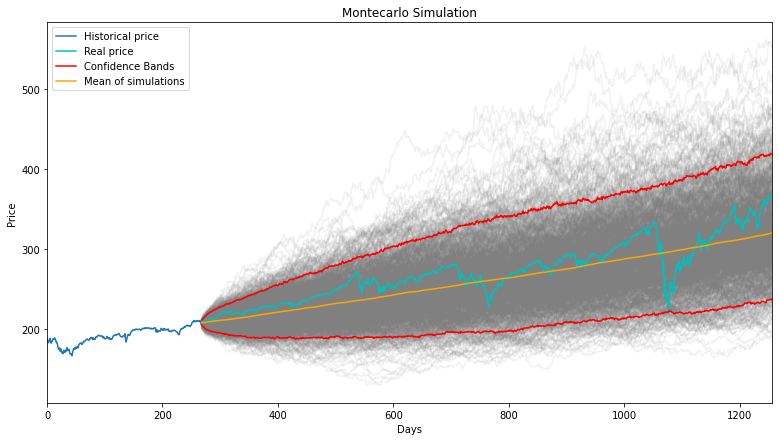

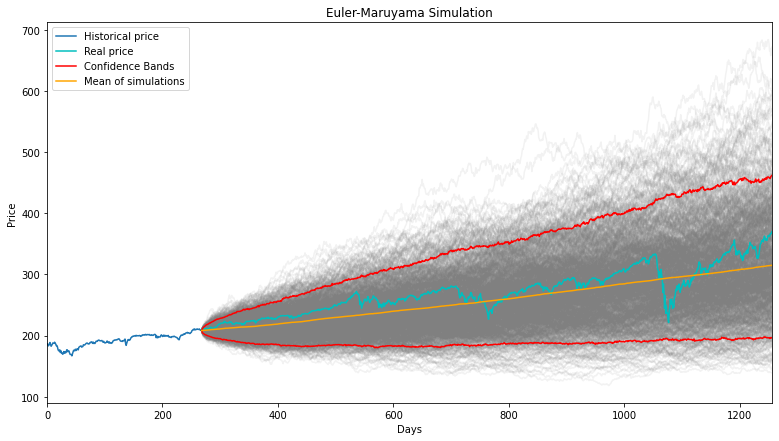

In [ ]:
plt.figure(figsize=(13,7))
plt.title('Montecarlo Simulation')
plt.plot(train_data['Adj Close'].values, label='Historical price')
for i in range(1, n_sims):
    sim = (mc_cum[i] * train_data['Adj Close'].iloc[-1])[:n2]
    plt.plot(range(n1, n1+n2, 1), sim, '0.5', alpha=.1, color='gray')
plt.plot(range(n1, n1+n2, 1), test_data['Adj Close'].values, 'c', label="Real price")
plt.plot(range(n1, n1+n2, 1), U_[:n2], 'r', label='Confidence Bands')
plt.plot(range(n1, n1+n2, 1), L_[:n2], 'r')
plt.plot(range(n1, n1+n2, 1), Mean_[:n2], 'orange', label = 'Mean of simulations')
plt.xlim([0, n1+n2])
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()



plt.figure(figsize=(13,7))
plt.title('Euler-Maruyama Simulation')
plt.plot(close_d1, label='Historical price')  # Plot the Data use to forecast
for traj in range(n_traj-1):
    plt.gray()
    plt.plot(range(n1, n1+n2, 1), xs_n[traj], '0.5', alpha=.1)
plt.plot(range(n1, n1+n2, 1), close_d2, 'c', label="Real price")
plt.plot(range(n1, n1+n2, 1), U, 'r', label='Confidence Bands')
plt.plot(range(n1, n1+n2, 1), L, 'r')
plt.plot(range(n1, n1+n2, 1), Mean, 'orange', label = 'Mean of simulations')
plt.xlim([0, n1+n2])
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

## Conclusion


It seems Montecarlo simulation bands become wider in the short term

But, in the medium and long term, they tend to become narrower than Euler-M. sim. bands